In [30]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
### 在huggingface 拉一个模型

In [31]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6"  # 指定使用 GPU 3

In [32]:
import os
import copy

import torch
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EvalPrediction
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [33]:
PATH = "/home/mcq2/GitHub/aes2/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"


train_df = pd.read_csv(PATH + "train.csv")
#data1 = pd.read_csv(PATHS.train_path)
persuade = pd.read_csv('/home/mcq2/GitHub/aes2/kaggle/input/additional_dataset/persuade_2.0_human_scores_demo_id_github.csv')


In [34]:
persuade.head(2)

,essay_id_comp,full_text,holistic_essay_score,word_count,prompt_name,task,assignment,source_text,gender,grade_level,ell_status,race_ethnicity,economically_disadvantaged,student_disability_status
0,423A1CA112E2,Phones\n\nModern humans today are always on th...,3,378,Phones and driving,Independent,Today the majority of humans own and operate c...,NaN,M,NaN,NaN,Black/African American,NaN,NaN
1,BC75783F96E3,This essay will explain if drivers should or s...,4,432,Phones and driving,Independent,Today the majority of humans own and operate c...,NaN,M,NaN,NaN,Black/African American,NaN,NaN


#### Find the number of train $|S_{train}|$

#### Find intersection $S_{train} \cap S_{persuade}$ and difference $S_{train} \setminus S_{persuade}$

In [35]:
intersection = pd.merge(train_df, persuade, on="full_text", how="inner")[["essay_id", "full_text", "score", "prompt_name"]].reset_index(drop=True)
difference = train_df[~train_df["essay_id"].isin(intersection["essay_id"])].reset_index(drop=True)
# print("len(intersection):", len(intersection))
# print("len(difference):", len(difference))

### Plot the histogram of prompts colored by score

In [36]:
## 将有score和关键词连起来
intersection["score_and_prompt"] = intersection["score"].astype(str) + "-" + intersection["prompt_name"]
intersection.head()

,essay_id,full_text,score,prompt_name,score_and_prompt
0,000d118,Many people have car where they live. The thin...,3,Car-free cities,3-Car-free cities
1,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,Does the electoral college work?,3-Does the electoral college work?
2,0030e86,If I were to choose between keeping the electo...,4,Does the electoral college work?,4-Does the electoral college work?
3,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,"""A Cowboy Who Rode the Waves""","3-""A Cowboy Who Rode the Waves"""
4,0036253,The challenge of exploring Venus\n\nThis stori...,2,Exploring Venus,2-Exploring Venus


In [37]:
## 将insertion 分为了两个部分，并且增加了一列在intersection里面
intersection["fold"] = None
splitter = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
folds = list(splitter.split(X=np.zeros(len(intersection)), y=intersection["score_and_prompt"].values))
for fold_idx, (_, val_idx) in enumerate(folds):
    intersection.loc[val_idx, "fold"] = fold_idx

### Visualize the split

### Convert prompt to prompt id
We're going to train a model to classify prompt. Currently, the target column `prompt_name` is a string, so we need to convert it to id and name it `label`.

In [38]:
### intersection中 把 “关键词” 修改为 修改为数字分类, 并且重命名为label
intersection["label"] =  intersection["prompt_name"].astype("category").cat.codes
intersection.head()

,essay_id,full_text,score,prompt_name,score_and_prompt,fold,label
0,000d118,Many people have car where they live. The thin...,3,Car-free cities,3-Car-free cities,0,1
1,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,Does the electoral college work?,3-Does the electoral college work?,0,2
2,0030e86,If I were to choose between keeping the electo...,4,Does the electoral college work?,4-Does the electoral college work?,1,2
3,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,"""A Cowboy Who Rode the Waves""","3-""A Cowboy Who Rode the Waves""",1,0
4,0036253,The challenge of exploring Venus\n\nThis stori...,2,Exploring Venus,2-Exploring Venus,1,4


In [39]:
## 建立一个pd, prompt_to_id， 内容为关键词和它对应的数值
prompt_to_id = intersection.drop_duplicates(subset=("prompt_name", "label"))[["prompt_name", "label"]]
label2id = {row["prompt_name"]: row["label"] for _, row in prompt_to_id.iterrows()}
id2label = {row["label"]: row["prompt_name"] for _, row in prompt_to_id.iterrows()}
prompt_to_id

,prompt_name,label
0,Car-free cities,1
1,Does the electoral college work?,2
3,"""A Cowboy Who Rode the Waves""",0
4,Exploring Venus,4
6,Driverless cars,3
11,Facial action coding system,5
36,The Face on Mars,6


### Instantiate the model & tokenizer
I will use `deberta-v3-xsmall` here for good trade-off of performance and speed.

In [40]:
checkpoint = "microsoft/deberta-v3-xsmall"

class ModelInit:
    def __init__(self, checkpoint, label2id, id2label):
        self.model = AutoModelForSequenceClassification.from_pretrained(
            checkpoint, 
            num_labels=len(label2id),
            label2id=label2id,
            id2label=id2label,
        )
        self.state_dict = copy.deepcopy(self.model.state_dict())
        
    def __call__(self):
        self.model.load_state_dict(self.state_dict)
        return self.model
    
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model_init = ModelInit(checkpoint, label2id=label2id, id2label=id2label)

/home/mcq2/anaconda3/envs/aes/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize the dataset
I will use `max_length=1024` here.

In [41]:
intersection_ds = Dataset.from_pandas(intersection)
diff_ds = Dataset.from_pandas(difference)
intersection_ds = intersection_ds.map(lambda i: tokenizer(i["full_text"], max_length=1024, truncation=True), batched=True)
diff_ds = diff_ds.map(lambda i: tokenizer(i["full_text"], max_length=1024, truncation=True), batched=True)

Map:   0%|          | 0/12871 [00:00<?, ? examples/s]

Map:   0%|          | 0/4436 [00:00<?, ? examples/s]

### Train prompt classifier

In [42]:
def compute_metrics(eval_pred: EvalPrediction) -> dict[str, float]:
    predictions = eval_pred.predictions
    y_true = eval_pred.label_ids
    y_pred = predictions.argmax(-1)
    acc = accuracy_score(y_true, y_pred)
    return {"acc": acc}

In [43]:
args = TrainingArguments(
    output_dir="output",
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    lr_scheduler_type="constant",
    warmup_ratio=0.0,
    num_train_epochs=1,
    weight_decay=0.01,
    optim="adamw_torch",
    fp16=torch.cuda.is_available()
)

/home/mcq2/anaconda3/envs/aes/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


/home/mcq2/anaconda3/envs/aes/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Acc
0,No log,0.122456,0.998757


/home/mcq2/anaconda3/envs/aes/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/mcq2/anaconda3/envs/aes/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Acc
0,No log,0.148660,0.998601


/home/mcq2/anaconda3/envs/aes/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


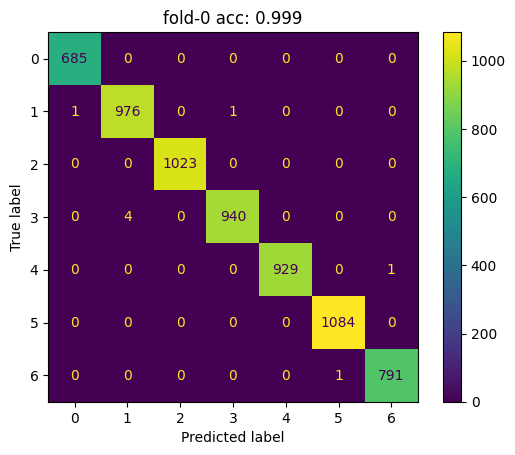

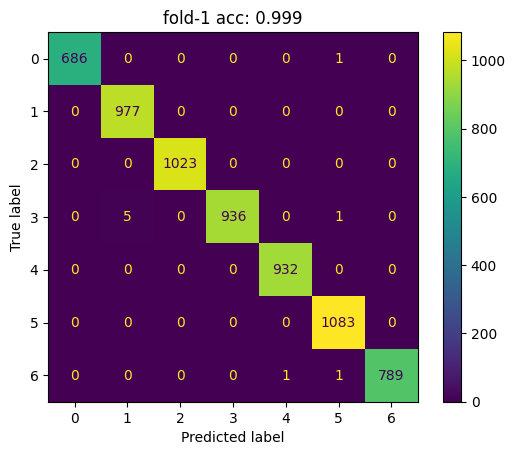

In [44]:
predictions = []

for fold_idx in np.unique(intersection_ds["fold"]):
    args.output_dir = os.path.join("output", f"fold_{fold_idx}")
    train_ds = intersection_ds.select([i for i, f in enumerate(intersection_ds["fold"]) if f != fold_idx])
    eval_ds = intersection_ds.select([i for i, f in enumerate(intersection_ds["fold"]) if f == fold_idx])
    trainer = Trainer(
        args=args, 
        model_init=model_init,
        train_dataset=train_ds, 
        eval_dataset=eval_ds, 
        tokenizer=tokenizer, 
        compute_metrics=compute_metrics
    )
    trainer.train()
    # predict on eval dataset to visualize the result
    preds = trainer.predict(eval_ds)
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(
        y_true=preds.label_ids, 
        y_pred=preds.predictions.argmax(-1),
        ax=ax
    )
    acc = accuracy_score(y_true=preds.label_ids, y_pred=preds.predictions.argmax(-1))
    ax.set_title(f"fold-{fold_idx} acc: {acc:.3f}")
    fig.show()
    # predict on difference dataset
    test_preds = trainer.predict(diff_ds)
    predictions.append(test_preds.predictions)
    
predictions = np.stack(predictions, axis=0).mean(axis=0)  # average the result of 2 folds

### Save the result

In [27]:
essay_id = diff_ds["essay_id"]
prompt_name = [id2label[i] for i in predictions.argmax(-1)]  # convert prompt id back to prompt name
result_df = pd.DataFrame({"essay_id": essay_id, "prompt_name": prompt_name, "predicted": [True] * len(essay_id)})
result_df

,essay_id,prompt_name,predicted
0,000d118,Car-free cities,True
1,000fe60,The Face on Mars,True
2,001ab80,Driverless cars,True
3,001bdc0,Exploring Venus,True
4,002ba53,Does the electoral college work?,True
...,...,...,...
17302,ffd378d,Exploring Venus,True
17303,ffddf1f,Facial action coding system,True
17304,fff016d,"""A Cowboy Who Rode the Waves""",True
17305,fffb49b,Exploring Venus,True


In [28]:
intersection_df = intersection[["essay_id", "prompt_name"]].copy()
intersection_df["predicted"] = False
final_df = pd.concat([result_df, intersection_df])
final_df.to_csv("predicted_prompt.csv", index=False)
final_df

,essay_id,prompt_name,predicted
0,000d118,Car-free cities,True
1,000fe60,The Face on Mars,True
2,001ab80,Driverless cars,True
3,001bdc0,Exploring Venus,True
4,002ba53,Does the electoral college work?,True
...,...,...,...
25991,18409261F5C2,Seeking multiple opinions,False
25992,D46BCB48440A,Seeking multiple opinions,False
25993,0FB0700DAF44,Seeking multiple opinions,False
25994,D72CB1C11673,Seeking multiple opinions,False
